In [1]:
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from sklearn.metrics import r2_score as R2
from skopt.space import Real, Categorical, Integer
from time import time
from skopt import BayesSearchCV
from functools import partial
import pprint

import warnings
warnings.filterwarnings('ignore')

In [2]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [3]:
# loads all data sets into a dict
def load_datasets(dirs: list, load_path: str) -> dict:
    files = ['soil_c','surf_water','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','plant_stress','photosynthesis','plant_growth']
    
    #files.append('soil_temp', 'canopy_temp') missing 
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = 'datasets/' + dr + load_path
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

In [4]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)
    x = x.drop(['DATE'], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True)
df_irr = to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True)
df_cool = to_pd(datasets['cool_temp_maize_soybean'], True, True)

# NEE = GPP - ER:
#GPP = GROSS PRIMARY PRODUCTION (TOTAL C INTAKE) 
#ER = total C uptake =  ECO_RH + ECO_RA =  autotrophic + heterotrophic respiration 
#NPP = GPP + ECO_RA
df_dry['NEE'] = df_dry['ECO_NPP'] - df_dry['ECO_RH']
df_irr['NEE'] = df_irr['ECO_NPP'] - df_irr['ECO_RH']
df_cool['NEE'] = df_cool['ECO_NPP'] - df_cool['ECO_RH']

df= pd.concat([df_dry, df_irr, df_cool])
y = df[target].copy()
#y = df[target].copy()
#df = df.drop(target, axis=1)

In [6]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

y = df[target].copy()
x = df[feat_cols]
x['WIND'] = x['WIND'] / 100

In [7]:
observed_df = pd.read_csv('datasets/extractedNEE_CUT_REF_NIGHT.csv')

observed_df['initial planting density (m-2)1'] = 8.2

x_observed = observed_df[feat_cols]
y_observed = observed_df['NEE']

for entr in x_observed.columns:
    x_observed[entr] = preprocessing.normalize([x_observed[entr]])[0]
y_observed = pd.Series(preprocessing.normalize([y_observed])[0], name='NEE')

X_train, X_test, y_train, y_test = train_test_split(
   x_observed, y_observed, test_size=0.33, random_state=41)

In [8]:
x_observed

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY
0,-0.008448,0.002943,-0.012605,0.000000,0.017072,0.009676,0.009852,0.005291,0.009351,0.021359,0.000053
1,-0.007237,0.003120,-0.009287,0.000000,0.010835,0.009669,0.007903,0.004961,0.009390,0.021359,0.000154
2,-0.009198,0.002920,-0.011451,0.004675,0.021395,0.012222,0.007335,0.004711,0.009432,0.021359,0.000255
3,-0.021263,0.001994,-0.022331,0.003280,0.027115,0.013767,0.011348,0.005252,0.009477,0.021359,0.000356
4,-0.014926,0.002278,-0.016221,0.001424,0.020603,0.010775,0.008683,0.005157,0.009527,0.021359,0.000458
...,...,...,...,...,...,...,...,...,...,...,...
2187,-0.000863,0.002748,-0.003106,0.002816,0.023302,0.012815,0.009976,0.005336,0.009234,0.021359,0.036606
2188,-0.005282,0.002588,-0.006845,0.000003,0.012708,0.012827,0.009566,0.005323,0.009258,0.021359,0.036707
2189,-0.005136,0.002437,-0.005813,0.046197,0.020563,0.012035,0.008217,0.005196,0.009285,0.021359,0.036808
2190,-0.008375,0.002307,-0.012196,0.000000,0.018173,0.010686,0.006136,0.004789,0.009316,0.021359,0.036909


In [10]:
y_observed

0       0.003268
1       0.003392
2       0.003217
3       0.003071
4       0.003815
          ...   
2187    0.004148
2188    0.002898
2189    0.002733
2190    0.001665
2191    0.020576
Name: NEE, Length: 2192, dtype: float64

In [9]:
x

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY
0,2.91,4.951854,-2.93,0.0,3.31524,0.630569,0.435766,3.190371,4.710812,6.2,0.520833
1,2.19,4.953446,-5.90,0.0,2.47068,0.630147,0.349557,2.944458,7.255759,6.2,1.520833
2,9.11,5.599835,-6.89,0.0,2.45952,0.796492,0.324438,2.766023,8.689023,6.2,2.520833
3,8.71,5.658164,-0.99,0.7,3.76056,0.897199,0.501948,3.159278,3.999532,6.2,3.520833
4,3.73,4.463433,-4.64,0.0,3.67992,0.702206,0.384053,3.058000,2.409738,6.2,4.520833
...,...,...,...,...,...,...,...,...,...,...,...
2917,0.90,-711.935654,-11.60,0.0,4.03272,0.490577,0.225464,716.425542,5.302800,6.6,360.520833
2918,3.30,-711.953454,-8.10,0.0,4.34232,0.564898,0.317146,716.419829,3.804480,6.6,361.520833
2919,0.70,-711.985770,-8.70,1.2,3.84336,0.633341,0.299815,716.397027,2.213640,6.6,362.520833
2920,-7.60,-712.013117,-24.20,1.6,9.20376,0.321801,0.055784,716.349076,6.843240,6.6,363.520833


In [11]:
y

0          0.236561
1          0.458370
2          0.718199
3          1.315061
4          1.592673
           ...     
2917    1578.580400
2918    1579.076800
2919    1579.545200
2920    1580.008600
2921    1580.393200
Name: NEE, Length: 8766, dtype: float64

#### Normalize using L2 regularization

In [17]:
for entr in x.columns:
    x[entr] = preprocessing.normalize([x[entr]])[0]
y = pd.Series(preprocessing.normalize([y])[0], name='NEE')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
   df, y, test_size=0.33, random_state=41)

In [16]:
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [14]:
# Setting the scoring function
scoring = make_scorer(partial(MSE, squared=False), 
                      greater_is_better=False)


In [30]:
# Setting the basic regressor

#if gpu available 
#reg = xg.XGBRegressor(random_state=41, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist')

reg = xg.XGBRegressor(random_state=41, booster='gbtree', objective='reg:squarederror')


# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

### Bayesian optimiser

In [31]:
#fix deprecated stuff*
np.int = np.int64

In [32]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                                  
                    cv=7,                                           
                    n_iter=120,                                       # max number of trials
                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=1,                                         # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=41)                                   # random state for replicability

# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (7 hours)

best_params = report_perf(opt, X_train, y_train, 'XGBoost_regression', 
                          callbacks=[overdone_control, time_limit_control])

XGBoost_regression took 1421.83 seconds,  candidates checked: 120, best CV score: -0.005 ± 0.001
Best parameters:
OrderedDict([('colsample_bytree', 0.1),
             ('learning_rate', 0.01),
             ('max_depth', 2),
             ('n_estimators', 5000),
             ('reg_alpha', 1e-09),
             ('reg_lambda', 100.0),
             ('subsample', 0.521519795176227)])



In [33]:
# Transferring the best parameters to our basic regressor
reg =xg.XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', **best_params)

In [34]:
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.1, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [35]:
# Predict the model
pred = reg.predict(X_test)

RMSE :  0.004288


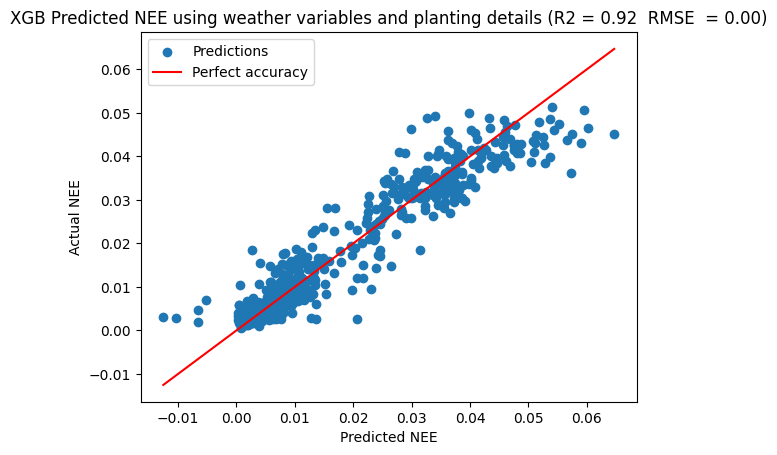

In [36]:
# Calculate R2 score
r2 = R2(y_test, pred)

rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

# Create scatter plot
plt.scatter(y_test, pred)

# Plot a red line for perfect accuracy
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='r')

# Add title and legend
plt.title("XGB Predicted " + target +  " using weather variables and planting details (R2 = %0.2f  RMSE  = %0.2f)" %  (r2, rmse))
plt.legend(['Predictions', 'Perfect accuracy'], loc='upper left')
plt.xlabel("Predicted NEE g C m-2 day-1")
plt.ylabel("Observed NEE g C m-2 day-1")

plt.savefig("results/HyperParam XGB" + target + "with_planting_details.png" )
# Show plot
plt.show()

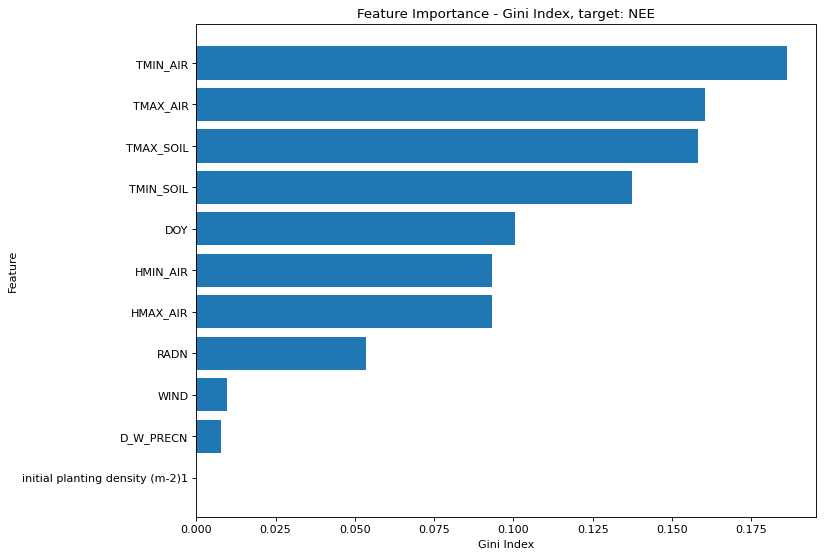

In [38]:
importances = pd.DataFrame({'GINI': reg.feature_importances_}, index=X_train.columns).sort_values(by='GINI', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8), dpi=80)
plt.barh(importances.index, importances['GINI'])

# Add title and axis labels
plt.title('Feature Importance - Gini Index, target: NEE')
plt.xlabel('Gini Index')
plt.ylabel('Feature')

plt.savefig('results/HyperParamFeatureImportanceGiniIndex' + target + "with_planting_details.png")
# Show the plot
plt.show()

In [39]:
import pickle
file_name = "models/observed_data.pkl"

# save
pickle.dump(reg, open(file_name, "wb"))
reg.save_model('models/observed_data.json')

In [8]:
hyper_params = ['colsample_bytree','learning_rate','max_depth','reg_alpha','reg_lambda','subsample']

In [9]:
simulated_xg = xg.XGBRegressor()
simulated_xg.load_model("models/xgb_reg.json")

In [18]:
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(
   x, y, test_size=0.33, random_state=41)

In [19]:
X_train_obs, X_test_obs, y_train_obs, y_test_obs = train_test_split(
   x_observed, y_observed, test_size=0.33, random_state=41)

In [20]:
X_train_sim

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY
1313,0.016805,0.000537,0.017947,0.042794,0.007042,0.016914,0.018908,0.000502,0.014573,0.012417,0.011016
1883,0.000540,0.000090,-0.014976,0.000000,0.009074,0.004553,0.001832,0.000069,0.010760,0.009389,0.002913
1057,0.007622,-0.018448,0.008098,0.000162,0.007092,0.009505,0.010939,0.018514,0.004663,0.009995,0.016536
730,0.003199,0.000118,-0.005845,0.000000,0.007870,0.005571,0.003943,0.000083,0.004677,0.009389,0.018512
1331,0.018660,0.000529,0.018991,0.000000,0.006589,0.019404,0.020280,0.000495,0.013208,0.012417,0.011928
...,...,...,...,...,...,...,...,...,...,...,...
2669,0.011405,-0.018386,0.004468,0.000000,0.004607,0.007021,0.008091,0.018478,0.015015,0.009995,0.005699
2278,0.005118,0.000246,-0.001899,0.000162,0.025748,0.006073,0.005398,0.000120,0.011044,0.012417,0.004382
1144,-0.006643,0.000077,-0.021008,0.000000,0.004885,0.001732,0.001069,0.000056,0.010312,0.012417,0.002457
931,0.019761,0.000758,0.022749,0.000000,0.009606,0.019323,0.018608,0.000625,0.015596,0.009389,0.010155


In [21]:
y_train_sim

4235    0.010893
1883    0.000239
6901    0.007013
730     0.015845
4253    0.014125
          ...   
8513    0.000981
5200    0.000539
4066    0.000150
931     0.006417
1984    0.003064
Name: NEE, Length: 5873, dtype: float64

In [24]:
X_train = pd.concat([X_train_sim, X_train_obs])
X_test = pd.concat([X_test_sim, X_test_obs])
Y_train = pd.concat([y_train_sim, y_train_obs])
Y_test = pd.concat([y_test_sim, y_test_obs])

In [27]:
reg = xg.XGBRegressor()
reg.load_model("models/bayesian_pretrain_gridsearch_fine_tune_xgb.json")

In [11]:
cross_val_params = {}

for param in hyper_params:
    sim_par = simulated_xg.get_xgb_params()[param]
    obs_par = observed_xg.get_xgb_params()[param]
    if (sim_par == obs_par):
        cross_val_params[param] = [sim_par]
    else:
        cross_val_params[param] = [sim_par,obs_par]
        
sim_n = simulated_xg.get_params(deep=True)['n_estimators']
obs_n = observed_xg.get_params(deep=True)['n_estimators']

if (sim_n==obs_n):
    cross_val_params['n_estimators'] = [sim_n]
else:
    cross_val_params['n_estimators'] = [sim_n, obs_par]

In [12]:
x_merged = pd.concat([x, X_train])
y_merged = pd.concat([y, y_train])

In [17]:
reg = xg.XGBRegressor(random_state=41, booster='gbtree', objective='reg:squarederror')

grid_search = GridSearchCV(estimator=reg, 
                           param_grid=cross_val_params, 
                           scoring=scoring, 
                           refit=False, 
                           n_jobs=-1, 
                           cv=7, 
                           verbose=0)

best_params = report_perf(grid_search, x_merged, y_merged)

model took 1093.59 seconds,  candidates checked: 16, best CV score: -0.004 ± 0.004
Best parameters:
{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'max_depth': 12,
 'n_estimators': 5000,
 'reg_alpha': 1e-09,
 'reg_lambda': 100.0,
 'subsample': 0.7282316492848115}



In [18]:
# Transferring the best parameters to our basic regressor
reg =xg.XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', **best_params)

In [ ]:
x,

In [ ]:
reg = xg.XGBRegressor()
reg.load_model("models/observed_data.json")

In [28]:
reg.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float'],
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [29]:
# Predict the model
pred = reg.predict(X_test)

RMSE :  0.002163


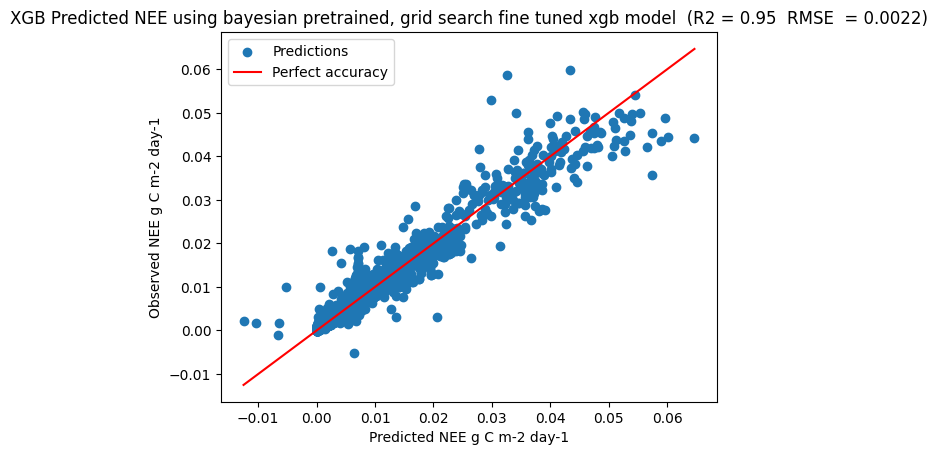

In [33]:
# Calculate R2 score
r2 = R2(Y_test, pred)

rmse = np.sqrt(MSE(Y_test, pred))
print("RMSE : % f" %(rmse))

# Create scatter plot
plt.scatter(Y_test, pred)

# Plot a red line for perfect accuracy
x = np.linspace(min(Y_test), max(Y_test), 100)
plt.plot(x, x, color='r')

# Add title and legend
plt.title("XGB Predicted " + target +  " using bayesian pretrained, grid search fine tuned xgb model  (R2 = %0.2f  RMSE  = %0.4f)" %  (r2, rmse))
plt.legend(['Predictions', 'Perfect accuracy'], loc='upper left')
plt.xlabel("Predicted NEE g C m-2 day-1")
plt.ylabel("Observed NEE g C m-2 day-1")

plt.savefig("results/bayesian pretrained, grid search fine tuned xgb model  " + target + "with_planting_details.png" )
# Show plot
plt.show()

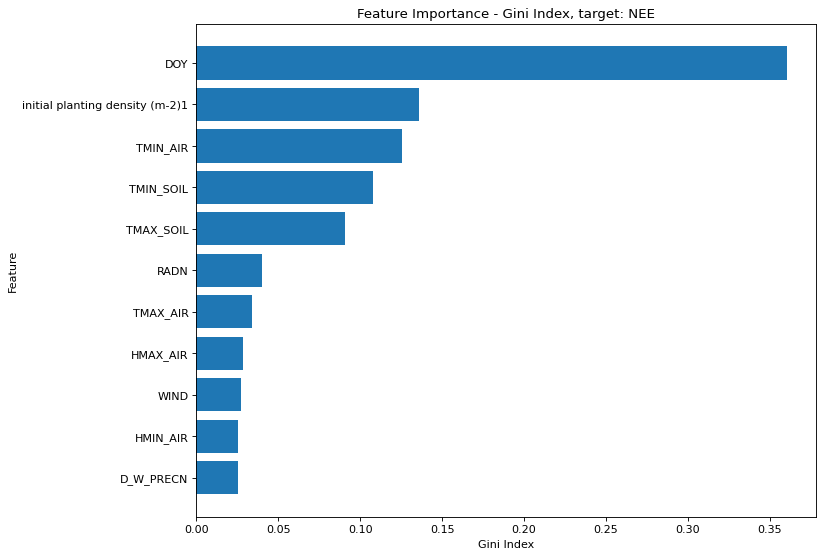

In [34]:
importances = pd.DataFrame({'GINI': reg.feature_importances_}, index=X_train.columns).sort_values(by='GINI', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8), dpi=80)
plt.barh(importances.index, importances['GINI'])

# Add title and axis labels
plt.title('Feature Importance - Gini Index, target: NEE')
plt.xlabel('Gini Index')
plt.ylabel('Feature')

plt.savefig('results/featureImpBayesianpretrainedgridsearchfinetunedxgbmodel' + target + "with_planting_details.png")
# Show the plot
plt.show()

In [34]:
import pickle
file_name = "models/bayesian_pretrain_gridsearch_fine_tune_xgb.pkl"

# save
pickle.dump(reg, open(file_name, "wb"))
reg.save_model('models/bayesian_pretrain_gridsearch_fine_tune_xgb.json')